# 1. Exploratory data analysis

In [1]:
# < Transfer the exploratory data analysis here >
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
df=pd.read_csv('/datasets/faces/labels.csv')
df.head()


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


The data does not contain any missing values

Found 7591 validated image filenames.
AxesSubplot(0.125,0.125;0.775x0.755)


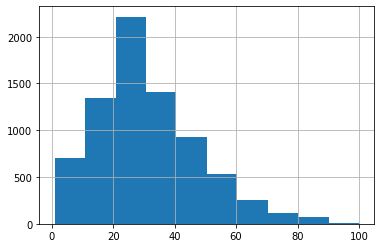

In [4]:
datagen = ImageDataGenerator(rescale=1./255)

datagen_flow = datagen.flow_from_dataframe(df,'/datasets/faces/final_files',
                x_col='file_name',y_col='real_age',class_mode='raw',
                target_size=(224,224),batch_size=32,seed=12345)

print(df['real_age'].hist())




Most prominent age group in our dataset is 20-30 years. The data is skewed. 

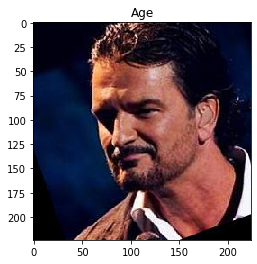

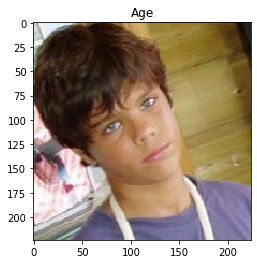

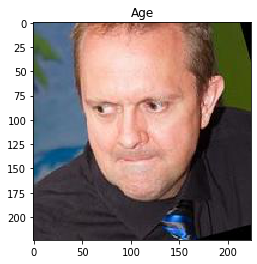

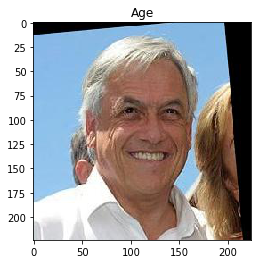

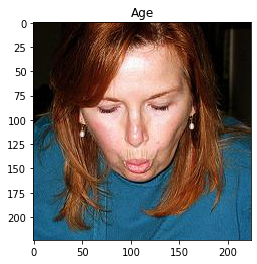

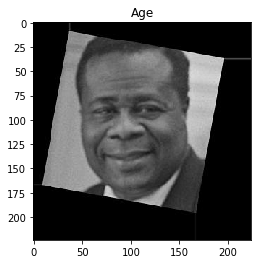

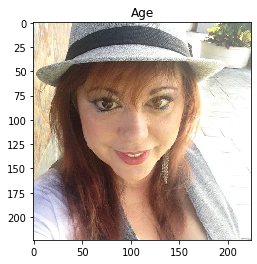

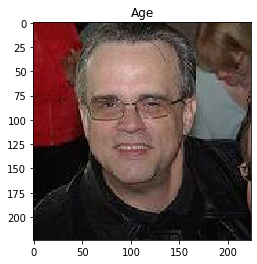

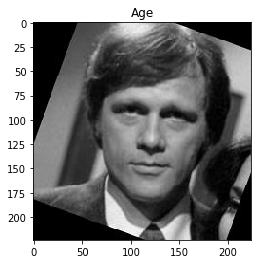

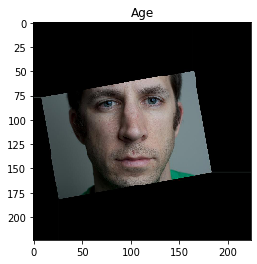

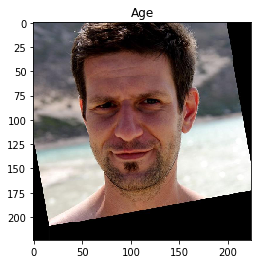

In [7]:
x,y=datagen_flow.next()
for i in range(11):
    plt.title('Age')
    plt.imshow(x[i])
    plt.show()

In [6]:
print(x.shape)

(32, 224, 224, 3)


Since we have given batch size 32 there are 32 images each having 224\*224 pixels and 3 color chanels

# 2. Model training

Transfer the model training code and the result of printing on the screen here.


(The code in this section is run on a separate GPU platform, so it is not designed as a cell with a code, but as a code in a text cell)

```python
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam

def load_train(path):
    
    df=pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,rescale=1./255,horizontal_flip=True)
    train_datagen_flow=train_datagen.flow_from_dataframe(df,path+'final_files/',x_col="file_name", 
    y_col='real_age',target_size=(224,224),batch_size=16,seed=12345,class_mode='raw',
    subset='training')
    
    return train_datagen_flow

def load_test(path):
    
    df=pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25,rescale=1./255)
    test_datagen_flow=test_datagen.flow_from_dataframe(df,path+'final_files/',x_col='file_name',
                      y_col='real_age',target_size=(224,224), batch_size=16, seed=12345,                                     class_mode='raw',subset='validation')
    
    return test_datagen_flow

def create_model(input_shape=(224,224,3)):
    
    backbone=ResNet50(input_shape=input_shape,weights='imagenet',include_top=False)
    model=Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1,activation='relu'))
    optimizer=Adam(lr=0.0001)
    model.compile(loss='mse',optimizer=optimizer,metrics=['mae'])
    
    return model

def train_model(model,train_data,test_data,batch_size=None,epochs=5,steps_per_epoch=None,
                validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch=len(train_data)
    if validation_steps is None:
        validation_steps=len(test_data)
    
    model.fit(train_data,validation_data=test_data,batch_size=batch_size,epochs=epochs,
              steps_per_epoch=steps_per_epoch,validation_steps=validation_steps,verbose=2)
    
    return model


```

```
Train for 475 steps, validate for 475 steps
Epoch 1/5
2020-12-26 15:55:56.248848: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-12-26 15:56:01.850325: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
475/475 - 157s - loss: 176.3109 - mae: 9.6848 - val_loss: 397.1264 - val_mae: 14.6909
Epoch 2/5
475/475 - 82s - loss: 67.3371 - mae: 6.2356 - val_loss: 61.3490 - val_mae: 6.0074
Epoch 3/5
475/475 - 82s - loss: 36.6688 - mae: 4.6438 - val_loss: 32.8412 - val_mae: 4.0857
Epoch 4/5
475/475 - 81s - loss: 22.3494 - mae: 3.6030 - val_loss: 27.2706 - val_mae: 4.0222
Epoch 5/5
475/475 - 82s - loss: 15.1282 - mae: 2.9612 - val_loss: 21.5802 - val_mae: 3.5331
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
475/475 - 40s - loss: 21.5802 - mae: 3.5331
Test MAE: 3.5331


```

# 3. Trained model analysis

From the histogram of age distribution we find that most of the people in our dataset belong to the age group 20-30 years. We trained the ResNet50 architecture with 5 epochs which obtained an MAE of 3.5331 on test set. We have augmented data with horizontal flip since that does not distort the image of a person's face.

By determining the age of the customers we can segment our customer base according to age and recommend products that are frequently purchased by their segment and target specific age groups for advertising certain products. This can significantly improve our sales and reduce advertising cost.